In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.2 MB/s eta 0:00:00


In [ ]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             confusion_matrix, roc_auc_score, matthews_corrcoef)
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

In [ ]:
# --- uyarıları kapatma ---
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", module="lightgbm")

In [ ]:
# --- read csv ---
data = pd.read_csv("/content/kepler.csv", comment='#')

In [ ]:
# --- feature columns ---
df_kp = data[['koi_disposition',
              'koi_pdisposition', 'koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss',
              'koi_fpflag_co', 'koi_fpflag_ec', 'koi_period', 'koi_impact',
              'koi_duration', 'koi_depth',
              'koi_prad', 'koi_teq', 'koi_insol',
              'koi_model_snr', 'koi_tce_plnt_num',
              'koi_steff',
              'koi_slogg', 'koi_srad',
              'ra', 'dec', 'koi_kepmag']].copy() # Use .copy() to avoid SettingWithCopyWarning

In [ ]:
#df_kp['label'] = df_kp['koi_disposition'].apply(lambda x: 1 if x in ['CONFIRMED'] else 0)

/tmp/ipython-input-1795939263.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_kp['label'] = df_kp['koi_disposition'].apply(lambda x: 1 if x in ['CONFIRMED'] else 0)


In [ ]:
# --- label encoding ---
le_disp = LabelEncoder()
df_kp.loc[:, 'koi_disposition'] = le_disp.fit_transform(df_kp['koi_disposition']) # Use .loc

In [ ]:
le_pdisp = LabelEncoder()
df_kp.loc[:, 'koi_pdisposition'] = le_pdisp.fit_transform(df_kp['koi_pdisposition']) # Use .loc

In [ ]:
# --- eksik değerleri KNNImputer ile doldurma ---
imputer = KNNImputer(n_neighbors=5)
X = imputer.fit_transform(df_kp.drop('koi_disposition', axis=1))
y = df_kp['koi_disposition'].values
#y = df_kp['label'].reset_index(drop=True)

In [ ]:
# --- Train/Val/Test split ---
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=2/9, random_state=42, stratify=y_trainval
)

In [ ]:
print(f"Train: {len(X_train)}, Validation: {len(X_val)}, Test: {len(X_test)}")

Train: 6694, Validation: 1913, Test: 957


In [ ]:
# --- weights for Ensemble ---
w1, w2 = 0.5931129060965006, 0.13535353285850302
w3 = 1 - w1 - w2

In [ ]:
# --- Models ---
def get_models():
    cat = CatBoostClassifier(
        iterations=808,
        learning_rate=0.011966745732207268,
        depth=9,
        l2_leaf_reg=5.930796491990693,
        verbose=0,
        random_seed=42
    )
    xgb = XGBClassifier(
        n_estimators=943,
        learning_rate=0.28470616589629755,
        max_depth=9,
        subsample=0.855470198198499,
        colsample_bytree=0.7437923290340979,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    lgbm = LGBMClassifier(
        n_estimators=1395,
        learning_rate=0.04469723749653884,
        max_depth=7,
        num_leaves=99,
        min_data_in_leaf=51,
        subsample=0.6456665591352713,
        colsample_bytree=0.9528071000721624,
        random_state=42,
        verbosity=-1
    )
    return cat, xgb, lgbm

In [ ]:
# --- Train fit ---
cat_model, xgb_model, lgbm_model = get_models()
cat_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lgbm_model.fit(X_train, y_train)

LGBMClassifier(colsample_bytree=0.9528071000721624,
               learning_rate=0.04469723749653884, max_depth=7,
               min_data_in_leaf=51, n_estimators=1395, num_leaves=99,
               random_state=42, subsample=0.6456665591352713, verbosity=-1)

In [ ]:
# --- Validation Ensemble ---
cat_val = cat_model.predict_proba(X_val)
xgb_val = xgb_model.predict_proba(X_val)
lgbm_val = lgbm_model.predict_proba(X_val)

In [ ]:
ensemble_val = (w1 * cat_val + w2 * xgb_val + w3 * lgbm_val)
ensemble_val_pred = np.argmax(ensemble_val, axis=1)

In [ ]:
print("\n--- VALIDATION SONUÇLARI ---")
print("Accuracy:", accuracy_score(y_val, ensemble_val_pred))
print("Precision:", precision_score(y_val, ensemble_val_pred, average="macro"))
print("Recall:", recall_score(y_val, ensemble_val_pred, average="macro"))
print("F1:", f1_score(y_val, ensemble_val_pred, average="macro"))
print("ROC-AUC:", roc_auc_score(y_val, ensemble_val, multi_class="ovr"))
#print("ROC-AUC:", roc_auc_score(y_val, ensemble_val[:, 1]))
print("MCC:", matthews_corrcoef(y_val, ensemble_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, ensemble_val_pred))



--- VALIDATION SONUÇLARI ---
Accuracy: 0.9309984317825405
Precision: 0.9065907633574265
Recall: 0.9027577062226838
F1: 0.9044297888267913
ROC-AUC: 0.9854024512387364
MCC: 0.8884527234047136
Confusion Matrix:
 [[322  74   0]
 [ 55 492   2]
 [  0   1 967]]


In [ ]:
# --- Test Ensemble ---
cat_test = cat_model.predict_proba(X_test)
xgb_test = xgb_model.predict_proba(X_test)
lgbm_test = lgbm_model.predict_proba(X_test)

In [ ]:
ensemble_test = (w1 * cat_test + w2 * xgb_test + w3 * lgbm_test)
ensemble_test_pred = np.argmax(ensemble_test, axis=1)

In [ ]:
print("\n--- TEST SONUÇLARI ---")
print("Accuracy:", accuracy_score(y_test, ensemble_test_pred))
print("F1:", f1_score(y_test, ensemble_test_pred, average="macro"))
print("ROC-AUC:", roc_auc_score(y_test, ensemble_test, multi_class="ovr"))


--- TEST SONUÇLARI ---
Accuracy: 0.9393939393939394
F1: 0.9155242705292589
ROC-AUC: 0.9880335392401354


In [ ]:
# --- 20-Fold Ensemble Cross Validation ---
kf = StratifiedKFold(n_splits=20, shuffle=True, random_state=42)
fold_acc = []

In [ ]:
print("\n--- 20-Fold Ensemble Cross Validation ---")
for i, (train_idx, val_idx) in enumerate(kf.split(X, y), 1):
    X_tr, X_va = X[train_idx], X[val_idx]
    y_tr, y_va = y[train_idx], y[val_idx]

    cat, xgb, lgbm = get_models()
    cat.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)
    lgbm.fit(X_tr, y_tr)

    cat_p = cat.predict_proba(X_va)
    xgb_p = xgb.predict_proba(X_va)
    lgbm_p = lgbm.predict_proba(X_va)

    ensemble_p = (w1 * cat_p + w2 * xgb_p + w3 * lgbm_p)
    ensemble_pred = np.argmax(ensemble_p, axis=1)

    acc = accuracy_score(y_va, ensemble_pred)
    fold_acc.append(acc)
    print(f"Fold {i}: ACC = {acc:.4f}")


--- 20-Fold Ensemble Cross Validation ---
Fold 1: ACC = 0.9353
Fold 2: ACC = 0.9395
Fold 3: ACC = 0.9395
Fold 4: ACC = 0.9582
Fold 5: ACC = 0.9289
Fold 6: ACC = 0.9477
Fold 7: ACC = 0.9435
Fold 8: ACC = 0.9331
Fold 9: ACC = 0.9163
Fold 10: ACC = 0.9519
Fold 11: ACC = 0.9435
Fold 12: ACC = 0.9561
Fold 13: ACC = 0.9456
Fold 14: ACC = 0.9289
Fold 15: ACC = 0.9310
Fold 16: ACC = 0.9331
Fold 17: ACC = 0.9247
Fold 18: ACC = 0.9331
Fold 19: ACC = 0.9519
Fold 20: ACC = 0.9205


In [ ]:
import pickle

# Assuming 'cat_model', 'xgb_model', and 'lgbm_model' are your trained models
ensemble_models = {
    'catboost': cat_model,
    'xgboost': xgb_model,
    'lightgbm': lgbm_model,
    'weights': (w1, w2, w3) # Include weights if needed for prediction
}

with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_models, f)

print("Ensemble model saved as ensemble_model.pkl")

Ensemble model saved as ensemble_model.pkl


In [ ]:
print("\n--- K-Fold Summary ---")
print("Average ACCURACY:", np.mean(fold_acc))
print("Best Fold ACCURACY:", np.max(fold_acc))


--- K-Fold Summary ---
Average ACCURACY: 0.9380991168840245
Best Fold ACCURACY: 0.9582463465553236


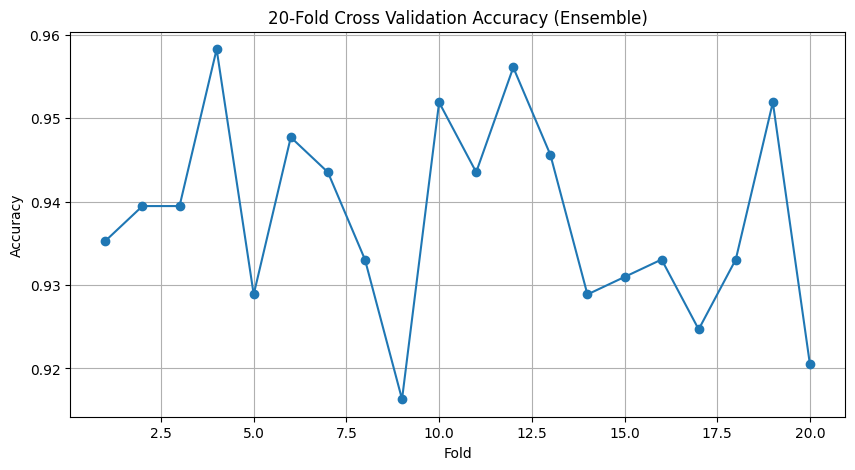

In [ ]:
# --- K-Fold graph ---
plt.figure(figsize=(10,5))
plt.plot(range(1, 21), fold_acc, marker='o')
plt.title("20-Fold Cross Validation Accuracy (Ensemble)")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()